# Logistical Regression Modeling
By: David Rusho

---

## Introduction

This notebook focuses on building a predictive model to answer the research question: "What factors contribute to positive airline customer satisfaction?". Building on the data exploration and cleaning performed in the previous notebook, we will use the preprocessed dataset to develop a logistic regression model. The initial data preparation included handling missing values, treating outliers, and performing a Variance Inflation Factor (VIF) analysis to reduce multicollinearity.

The primary objective of this notebook is to train and evaluate a logistic regression model. The process will involve:

- **Feature Selection**: Using backward stepwise elimination with `statsmodels` to identify the most statistically significant predictors (p<0.05).
    
- **Model Training**: Training the final logistic regression model using `scikit-learn` on the selected features.
    
- **Performance Evaluation**: Assessing the model's predictive power using accuracy, a confusion matrix, and a classification report.
    

This analysis will test the following hypotheses:

- **Null Hypothesis**: The logistic regression model indicates that there is no significant relationship between the predictor variable "Satisfaction" and the explanatory variables.
    
- **Alternative Hypothesis**: The logistic regression model indicates that there is a significant relationship between the predictor variable "Satisfaction" and the explanatory variables.

---

## Data Dictionary

| #  | Column                             | Datatype        | Description                                           |
|----|------------------------------------|-----------------|-------------------------------------------------------|
| 1  | Age                                | Quantitative    | Age of the customer.                                  |
| 2  | Arrival Delay in Minutes           | Quantitative    | Total arrival delay in minutes.                       |
| 3  | Baggage handling                   | Quantitative    | Rating of baggage handling satisfaction (1 to 5).     |
| 4  | Class                              | Qualitative     | Class of travel: 'Business', 'Eco', or 'Eco Plus’.    |
| 5  | Checkin service                    | Quantitative    | Rating of check-in service satisfaction (1 to 5).     |
| 6  | Cleanliness                        | Quantitative    | Rating of cleanliness satisfaction (1 to 5).          |
| 7  | Customer Type                      | Qualitative     | Type of customer: 'Loyal Customer' or 'Disloyal Customer’. |
| 8  | Departure Delay in Minutes         | Quantitative    | Total departure delay in minutes.                     |
| 9  | Departure/Arrival time convenient  | Quantitative    | Rating of the convenience of departure/arrival time (1 to 5). |
| 10 | Ease of Online booking             | Quantitative    | Rating of ease of online booking satisfaction (1 to 5). |
| 11 | Food and drink                     | Quantitative    | Rating of food and drink quality provided during the flight (1 to 5). |
| 12 | Gender                             | Qualitative     | Not provided in the data dictionary                   |
| 13 | Gate location                      | Quantitative    | Rating of gate location convenience (1 to 5).         |
| 14 | Flight Distance                    | Quantitative    | The distance of the flight in kilometres              |
| 15 | Inflight entertainment             | Quantitative    | Rating of inflight entertainment satisfaction (1 to 5). |
| 16 | Inflight wifi service              | Quantitative    | Rating of inflight wifi service satisfaction (1 to 5). |
| 17 | Leg room service                   | Quantitative    | Rating of leg room service satisfaction (1 to 5).     |
| 18 | Online boarding                    | Quantitative    | Rating of online boarding satisfaction (1 to 5).      |
| 19 | Online support                     | Quantitative    | Rating of online customer support satisfaction (1 to 5). |
| 20 | On-board service                   | Quantitative    | Rating of on-board service satisfaction (1 to 5).     |
| 21 | Seat comfort                       | Quantitative    | Rating of seat comfort provided during the flight (1 to 5). |
| 22 | Type of Travel                     | Qualitative     | Purpose of the travel: 'Business travel' or 'Personal Travel’. |

---


#### Install Python Libraries


In [ ]:
# cell 1

!pip3 install matplotlib
!pip3 install missingno
!pip3 install pandas
!pip3 install scipy
!pip3 install scikit-learn

#### Import Libaries


In [ ]:
# cell 2

# Standard Libraries
import warnings
import os

# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Statistical Models
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno

# Miscellaneous
warnings.filterwarnings('ignore')

## Loading Data
#### Load CSV into Pandas


In [ ]:
# cell 3

# Increase column display/print range to display all columns
pd.set_option("display.max_columns", None)

# Get the current working directory
cwd = os.getcwd()

# Specify the relative file path
# dataset contains only the features selected after the VIF analysis, making it ready for modeling.
relative_path = "../data/processed/final_airline_data.csv"

# Combine the current working directory with the relative file path
file_path = os.path.join(cwd, relative_path)

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first 3 rows of the DataFrame
df.head(3)

,Checkin service,Departure/Arrival time convenient,Age,Flight Distance,Class_dummy_Eco,Type of Travel_dummy_Personal Travel,Customer Type_dummy_disloyal Customer,Class_dummy_Eco Plus,satisfaction
0,5,0,65,265,1,1,0,0,1
1,2,0,47,2464,0,1,0,0,1
2,4,0,15,2138,1,1,0,0,1


In [15]:
# cell 4

# Define the dependent (target) variable
dependent_var = 'satisfaction'

# Define the predictors by dropping the dependent variable from the list of columns
predictors = df.columns.drop(dependent_var).tolist()

print("Target Variable:", dependent_var)
print("Predictors:", predictors)

Target Variable: satisfaction
Predictors: ['Checkin service', 'Departure/Arrival time convenient', 'Age', 'Flight Distance', 'Class_dummy_Eco', 'Type of Travel_dummy_Personal Travel', 'Customer Type_dummy_disloyal Customer', 'Class_dummy_Eco Plus']


## 4. Model Training and Feature Selection

To build the most interpretable and robust model, we will use **backward stepwise elimination**. This method starts with a model that includes all potential predictors and iteratively removes the least significant feature (the one with the highest p-value) until all remaining features are statistically significant (typically p < 0.05).

We will use the `statsmodels` library for this process because it provides detailed statistical summaries, including the p-values needed for feature selection.

In [ ]:
import statsmodels.api as sm

# Define the dependent variable
dependent_var = 'satisfaction'

# Define the initial set of predictors from the cleaned data
predictors = df.columns.drop(dependent_var).tolist()
df_elimination = df.copy()

while True:
    X = df_elimination[predictors]
    X_with_constant = sm.add_constant(X)
    y = df_elimination[dependent_var]

    # Fit the model
    logit_model = sm.Logit(y, X_with_constant)
    result = logit_model.fit(disp=0)  # disp=0 suppresses convergence messages

    # Get p-values and remove the highest one if it's > 0.05
    pvalues = result.pvalues.drop('const')
    max_pvalue = pvalues.max()

    if max_pvalue > 0.05:
        feature_to_remove = pvalues.idxmax()
        predictors.remove(feature_to_remove)
        print(
            f"Removing feature: {feature_to_remove} (p-value: {max_pvalue:.4f})")
    else:
        # All remaining features are significant
        print("\nBackward elimination complete. Final model summary:")
        print(result.summary())
        break

# Store the final list of predictors
final_predictors = predictors


Backward elimination complete. Final model summary:
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               129880
Model:                          Logit   Df Residuals:                   129871
Method:                           MLE   Df Model:                            8
Date:                Tue, 22 Jul 2025   Pseudo R-squ.:                  0.1873
Time:                        20:54:07   Log-Likelihood:                -72690.
converged:                       True   LL-Null:                       -89443.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.7038      0.036     19.668      0.000       0.634       0.7

## Model Evaluation

With the statistically significant features identified, we will now train the final logistic regression model using `scikit-learn` to evaluate its predictive performance on unseen data. The data will be split into an 80/20 training and testing set, and the features will be scaled using `RobustScaler` to handle potential outliers.

In [16]:
# cell 5

# # Copy the dataframe for evaluation
df_eval = df.copy()

# Add a constant to the independent value
X = df_eval[predictors]
y = df_eval[dependent_var]

# Split the data, train the model, make predictions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the logistic regression model
logreg = LogisticRegression(random_state=42).fit(
    X_train_scaled,
    y_train
)
y_pred = logreg.predict(X_test_scaled)
log_r = logreg.score(X_test_scaled, y_test)

# Print the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix\n {matrix}")

Confusion Matrix
 [[ 7299  4376]
 [ 3633 10668]]


In [ ]:
# Use the final predictors from backward elimination
X = df_eval[final_predictors]
y = df_eval[dependent_var]

# Split the data, train the model, make predictions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the final logistic regression model
logreg = LogisticRegression(random_state=42).fit(
    X_train_scaled,
    y_train
)
y_pred = logreg.predict(X_test_scaled)

# Print the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix\n {matrix}")

Confusion Matrix
 [[ 7299  4376]
 [ 3633 10668]]


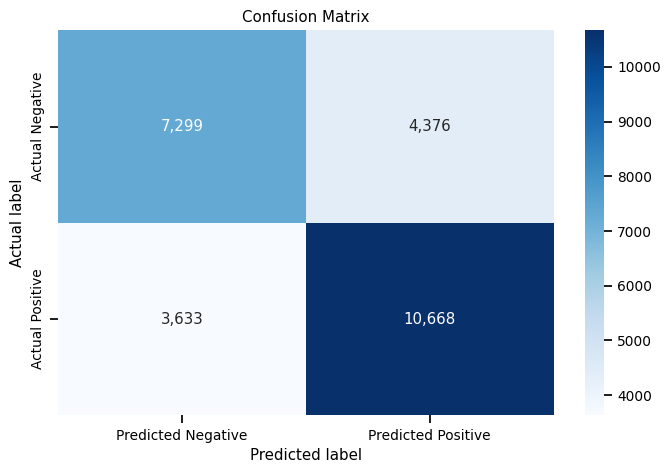

In [18]:
# cell 6

# Adjust the font scale to reduce size
sns.set_context('notebook', font_scale=.9)
plt.figure(figsize=(8, 5))

# Convert matrix values to string format with commas for thousands
annot_matrix = np.vectorize(lambda x: f'{x:,}')(matrix)

# Create the heatmap for the confusion matrix with custom annotations
sns.heatmap(matrix, annot=annot_matrix, fmt='', cmap='Blues', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
# cell 7

# Compute accuracy score of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of logistical regression classifier: {accuracy:.2f}")

# Classification Report for reduced model
y_pred = logreg.predict(X_test_scaled)
report = classification_report(
    y_test, y_pred, zero_division=0, output_dict=True)

print("Classification Report\n")

# Create a DataFrame from the classification report
report_df = pd.DataFrame(report).transpose().round(3)

# Apply formatting to add commas to numbers, excluding the index
formatted_report_df = report_df.applymap(
    lambda x: f'{x:,.3f}' if isinstance(x, float) else x)

formatted_report_df

Accuracy of logistical regression classifier: 0.69
Classification Report



,precision,recall,f1-score,support
0,0.668,0.625,0.646,"11,675.000"
1,0.709,0.746,0.727,"14,301.000"
accuracy,0.692,0.692,0.692,0.692
macro avg,0.688,0.686,0.686,"25,976.000"
weighted avg,0.690,0.692,0.691,"25,976.000"


### Interpretation of Evaluation Metrics

The logistic regression model achieved an overall accuracy of 69% in predicting airline customer satisfaction. Based on these results, the null hypothesis—that there is no significant relationship between the predictor variables and customer satisfaction—is rejected in favor of the alternative hypothesis.


The model's performance metrics are as follows:

Dissatisfied Customers (Class 0):
- Precision: 0.67
- Recall: 0.63
- F1-Score: 0.65

Satisfied Customers (Class 1):
- Precision: 0.71
- Recall: 0.75
- F1-Score: 0.73

The significant predictor variables identified through backward elimination—such as "Checkin service," "Departure/Arrival time convenience," and "Customer Type"—are statistically significant factors in determining passenger satisfaction.


Business Recommendation: Based on these findings, the airline should prioritize improvements in the areas identified as key drivers of satisfaction. Focusing resources on optimizing check-in services and minimizing flight delays could lead to higher overall customer satisfaction and improved loyalty.